In [86]:
# Εισαγωγή βιβλιοθηκών
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime
import wordcloud
!python -m spacy download el_core_news_sm
import spacy
import glob
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')


In [87]:
df_dealnews = pd.read_csv('dealnews.csv')
df_dealnews.head()

,web-scraper-order,web-scraper-start-url,pages,pages-href,post,post-href,title,date,body_intro,body_main
0,1593373931-458,http://www.dealnews.gr/epixeiriseis,Επόμενο,http://www.dealnews.gr/epixeiriseis?start=572,ENERGEAN: Aλλαγές στη διοίκηση της στην Eλλάδα,http://www.dealnews.gr/roi/item/287911-ENERGEA...,ENERGEAN: Aλλαγές στη διοίκηση της στην Eλλάδα,12. 04. 2020,"Nέα σελίδα για την Energean στην Eλλάδα, καθώς...",Mέχρι την ολοκλήρωση της εξαγοράς της Edison E...
1,1593373510-265,http://www.dealnews.gr/epixeiriseis,Επόμενο,http://www.dealnews.gr/epixeiriseis?start=338,Στο πλευρό των ευπαθών ομάδων η ACS την…,http://www.dealnews.gr/roi/item/290807-%CE%A3%...,Στο πλευρό των ευπαθών ομάδων η ACS την περίοδ...,19. 05. 2020,Συνεργασία ACS με κοινωφελείς φορείς για δωρεά...,Επιπροσθέτως της συμμετοχής της ACS στις μεγάλ...
2,1593373820-407,http://www.dealnews.gr/epixeiriseis,Επόμενο,http://www.dealnews.gr/epixeiriseis?start=520,ISOMAT: Δωρεά 10 σύγχρονων ηλεκτρικών κλινών Μ...,http://www.dealnews.gr/roi/item/287590-ISOMAT-...,ISOMAT: Δωρεά 10 σύγχρονων ηλεκτρικών κλινών Μ...,18. 04. 2020,Η ISOMAT προχώρησε στη δωρεά 10 σύγχρονων ηλεκ...,Έχοντας γνώση του δύσκολου έργου που επιτελείτ...
3,1593373464-244,http://www.dealnews.gr/epixeiriseis,Επόμενο,http://www.dealnews.gr/epixeiriseis?start=312,Γεωργιάδης: Επεξεργαζόμαστε σχέδιο για την Aegean,http://www.dealnews.gr/roi/item/291019-%CE%93%...,Γεωργιάδης: Επεξεργαζόμαστε σχέδιο για την Aegean,21. 05. 2020,NaN,Σε φάση επεξεργασίας σχεδίου για τη στήριξη τη...
4,1593373702-354,http://www.dealnews.gr/epixeiriseis,Επόμενο,http://www.dealnews.gr/epixeiriseis?start=442,Senfluga: Δωρεά 500.000 ευρώ στο ΕΣΥ,http://www.dealnews.gr/roi/item/289461-Senflug...,Senfluga: Δωρεά 500.000 ευρώ στο ΕΣΥ,04. 05. 2020,"Η κοινοπραξία Senfluga, που αποτελεί το βασικό...","Για τον σκοπό αυτό, η εταιρεία προφέρει 500.00..."


In [88]:
# Αφαίρεση στηλών

df_dealnews.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'pages', 'pages-href', 'post', 'post-href'], axis = 1, inplace=True)

In [89]:
# Καθάρισμα δεδομένων από NaN values

df_dealnews.isnull().sum()
missing_values = ["n/a", "na", "NaN", "--", 999, 9999]   
df_dealnews.replace(to_replace = missing_values, value = np.nan, inplace = True)
df_dealnews.dropna(inplace=True)

# Aφαίρεση κενών από τα άρθρα
df_dealnews['title'] = df_dealnews['title'].str.replace("\t", '')
df_dealnews['title'] = df_dealnews['title'].str.replace("\n", '')
df_dealnews['body_intro'] = df_dealnews['body_intro'].str.replace('\t', '')
df_dealnews['body_intro'] = df_dealnews['body_intro'].str.replace('\n', '')
df_dealnews['body_main'] = df_dealnews['body_main'].str.replace('\t', '')
df_dealnews['body_main'] = df_dealnews['body_main'].str.replace('\n', '')

print(df_dealnews.shape)
df_dealnews.head()

(742, 4)


,title,date,body_intro,body_main
0,ENERGEAN: Aλλαγές στη διοίκηση της στην Eλλάδα,12. 04. 2020,"Nέα σελίδα για την Energean στην Eλλάδα, καθώς...",Mέχρι την ολοκλήρωση της εξαγοράς της Edison E...
1,Στο πλευρό των ευπαθών ομάδων η ACS την περίοδ...,19. 05. 2020,Συνεργασία ACS με κοινωφελείς φορείς για δωρεά...,Επιπροσθέτως της συμμετοχής της ACS στις μεγάλ...
2,ISOMAT: Δωρεά 10 σύγχρονων ηλεκτρικών κλινών Μ...,18. 04. 2020,Η ISOMAT προχώρησε στη δωρεά 10 σύγχρονων ηλεκ...,Έχοντας γνώση του δύσκολου έργου που επιτελείτ...
4,Senfluga: Δωρεά 500.000 ευρώ στο ΕΣΥ,04. 05. 2020,"Η κοινοπραξία Senfluga, που αποτελεί το βασικό...","Για τον σκοπό αυτό, η εταιρεία προφέρει 500.00..."
5,Πράσινο από τους ομολογιούχους στο σχέδιο διάσ...,20. 03. 2020,"Ενέκριναν οι κάτοχοι του ομολόγου των 249,5 εκ...",Με ανακοίνωση που εξέδωσε στο Χρηματιστήριο γν...


In [90]:
# Μετατροπή της ημερομηνίας από object σε datetime σε νέα στήλη

print(df_dealnews.dtypes)
df_dealnews['Datetime'] = pd.to_datetime(df_dealnews['date'].str.replace('.',''), format="%d %m %Y", exact=True)
print(df_dealnews.dtypes)
df_dealnews.head()

title         object
date          object
body_intro    object
body_main     object
dtype: object
title                 object
date                  object
body_intro            object
body_main             object
Datetime      datetime64[ns]
dtype: object


,title,date,body_intro,body_main,Datetime
0,ENERGEAN: Aλλαγές στη διοίκηση της στην Eλλάδα,12. 04. 2020,"Nέα σελίδα για την Energean στην Eλλάδα, καθώς...",Mέχρι την ολοκλήρωση της εξαγοράς της Edison E...,2020-04-12
1,Στο πλευρό των ευπαθών ομάδων η ACS την περίοδ...,19. 05. 2020,Συνεργασία ACS με κοινωφελείς φορείς για δωρεά...,Επιπροσθέτως της συμμετοχής της ACS στις μεγάλ...,2020-05-19
2,ISOMAT: Δωρεά 10 σύγχρονων ηλεκτρικών κλινών Μ...,18. 04. 2020,Η ISOMAT προχώρησε στη δωρεά 10 σύγχρονων ηλεκ...,Έχοντας γνώση του δύσκολου έργου που επιτελείτ...,2020-04-18
4,Senfluga: Δωρεά 500.000 ευρώ στο ΕΣΥ,04. 05. 2020,"Η κοινοπραξία Senfluga, που αποτελεί το βασικό...","Για τον σκοπό αυτό, η εταιρεία προφέρει 500.00...",2020-05-04
5,Πράσινο από τους ομολογιούχους στο σχέδιο διάσ...,20. 03. 2020,"Ενέκριναν οι κάτοχοι του ομολόγου των 249,5 εκ...",Με ανακοίνωση που εξέδωσε στο Χρηματιστήριο γν...,2020-03-20


In [91]:
df_dealnews['year'] = pd.DatetimeIndex(df_dealnews['Datetime']).year
df_dealnews['month'] = pd.DatetimeIndex(df_dealnews['Datetime']).month
df_dealnews['day'] = pd.DatetimeIndex(df_dealnews['Datetime']).day

In [92]:
# Ένωση της στήλης "body_intro" και "body_main"

df_dealnews['body'] = df_dealnews['body_intro'] +" "+ df_dealnews['body_main']
df_dealnews.head()

,title,date,body_intro,body_main,Datetime,year,month,day,body
0,ENERGEAN: Aλλαγές στη διοίκηση της στην Eλλάδα,12. 04. 2020,"Nέα σελίδα για την Energean στην Eλλάδα, καθώς...",Mέχρι την ολοκλήρωση της εξαγοράς της Edison E...,2020-04-12,2020,4,12,"Nέα σελίδα για την Energean στην Eλλάδα, καθώς..."
1,Στο πλευρό των ευπαθών ομάδων η ACS την περίοδ...,19. 05. 2020,Συνεργασία ACS με κοινωφελείς φορείς για δωρεά...,Επιπροσθέτως της συμμετοχής της ACS στις μεγάλ...,2020-05-19,2020,5,19,Συνεργασία ACS με κοινωφελείς φορείς για δωρεά...
2,ISOMAT: Δωρεά 10 σύγχρονων ηλεκτρικών κλινών Μ...,18. 04. 2020,Η ISOMAT προχώρησε στη δωρεά 10 σύγχρονων ηλεκ...,Έχοντας γνώση του δύσκολου έργου που επιτελείτ...,2020-04-18,2020,4,18,Η ISOMAT προχώρησε στη δωρεά 10 σύγχρονων ηλεκ...
4,Senfluga: Δωρεά 500.000 ευρώ στο ΕΣΥ,04. 05. 2020,"Η κοινοπραξία Senfluga, που αποτελεί το βασικό...","Για τον σκοπό αυτό, η εταιρεία προφέρει 500.00...",2020-05-04,2020,5,4,"Η κοινοπραξία Senfluga, που αποτελεί το βασικό..."
5,Πράσινο από τους ομολογιούχους στο σχέδιο διάσ...,20. 03. 2020,"Ενέκριναν οι κάτοχοι του ομολόγου των 249,5 εκ...",Με ανακοίνωση που εξέδωσε στο Χρηματιστήριο γν...,2020-03-20,2020,3,20,"Ενέκριναν οι κάτοχοι του ομολόγου των 249,5 εκ..."


In [93]:
# Καθάρισμα δεδομένων από περιττά κείμενα

keywords = ['covid', 'COVID','Covid','κορωνοϊό', 'κορονοϊό','κοροναϊό', 'πανδημία', 'lockdown', 'αναστολή', ' ιός', 'SARS']
df_articles = pd.DataFrame(df_dealnews[df_dealnews.apply(lambda x: any([word in x['title'] or word in x['body'] for word in keywords]), axis=1)])
df_articles.reset_index(inplace = True)
df_articles.sort_values('Datetime', ascending=True).head(200)
df_articles.shape

(341, 10)

In [94]:
# Ανάλυση συναισθήματος

filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"
emolex_df = pd.read_csv(filepath)
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(inplace = True)
print(emolex_df.head())

   index             word  Positive  Negative  ...  Joy  Sadness  Surprise  Trust
0      0            αφεση       1.0       0.0  ...  0.0      0.0       0.0    0.0
1      1  ενορκη βεβαιωση       0.0       0.0  ...  0.0      0.0       0.0    0.0
2      2          εχοντας       0.0       0.0  ...  0.0      0.0       0.0    0.0
3      3              εχω       0.0       0.0  ...  0.0      0.0       0.0    0.0
4      4             οριο       0.0       0.0  ...  0.0      0.0       0.0    0.0

[5 rows x 12 columns]


In [95]:
# Έλεγχος λέξεων από το συναισθηματικό λεξικό

nlp = spacy.load('el_core_news_sm')
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',
                      stop_words= nlp.Defaults.stop_words,
                      ngram_range=(1, 2))

matrix = vec.fit_transform(df_articles['body'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
print(wordcount_df)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'απο', 'αποψε', 'αρα', 'αραγε', 'αρκετα', 'αρκετες', 'αρχικα', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια', 'βεβαιοτατα', 'γιατι', 'γρηγορα', 'γυρω', 'δεινα', 'δεξια', 'δηθεν', 'δηλαδη', 'διαρκως', 'δικα', 'δικο', 'δικοι', 'δικος', 'δικου', 'δικους', 'διολου', 'διπλα', 'διχως', 'εαν', 'εαυτο', 'εαυτον', 'εαυτου', 'εαυτους', 'εαυτων', 'εγιναν', 'εγινε', 

     αφεση  ενορκη βεβαιωση  εχοντας  ...  νεοτερος  ζεφυρος  ζουμ
0        0                0        1  ...         0        0     0
1        0                0        2  ...         0        0     0
2        0                0        0  ...         0        0     0
3        0                0        0  ...         0        0     0
4        0                0        0  ...         0        0     0
..     ...              ...      ...  ...       ...      ...   ...
336      0                0        0  ...         0        0     0
337      0                0        0  ...         0        0     0
338      0                0        0  ...         0        0     0
339      0                0        0  ...         0        0     0
340      0                0        0  ...         0        0     0

[341 rows x 13161 columns]


In [96]:
emolex_df[emolex_df.Anger == 1].tail()

,index,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13094,13104,διεξοδος,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13096,13106,ζωυφια,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
13100,13110,θυματοποιω,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
13128,13138,αποτυχημενος,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13156,13166,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [97]:
# Σύνολο λέξεων με θετικό ή αρνητικό συναισθηματικό φορτίο

positive_words = emolex_df[emolex_df.Positive == 1]['word']
df_articles['positivity'] = wordcount_df[positive_words].sum(axis=1)
negative_words = emolex_df[emolex_df.Negative == 1]['word']
df_articles['negativity'] = wordcount_df[negative_words].sum(axis=1)
df_articles.head()

,index,title,date,body_intro,body_main,Datetime,year,month,day,body,positivity,negativity
0,1,Στο πλευρό των ευπαθών ομάδων η ACS την περίοδ...,19. 05. 2020,Συνεργασία ACS με κοινωφελείς φορείς για δωρεά...,Επιπροσθέτως της συμμετοχής της ACS στις μεγάλ...,2020-05-19,2020,5,19,Συνεργασία ACS με κοινωφελείς φορείς για δωρεά...,20,7
1,2,ISOMAT: Δωρεά 10 σύγχρονων ηλεκτρικών κλινών Μ...,18. 04. 2020,Η ISOMAT προχώρησε στη δωρεά 10 σύγχρονων ηλεκ...,Έχοντας γνώση του δύσκολου έργου που επιτελείτ...,2020-04-18,2020,4,18,Η ISOMAT προχώρησε στη δωρεά 10 σύγχρονων ηλεκ...,5,3
2,4,Senfluga: Δωρεά 500.000 ευρώ στο ΕΣΥ,04. 05. 2020,"Η κοινοπραξία Senfluga, που αποτελεί το βασικό...","Για τον σκοπό αυτό, η εταιρεία προφέρει 500.00...",2020-05-04,2020,5,4,"Η κοινοπραξία Senfluga, που αποτελεί το βασικό...",4,0
3,6,Βενέτης: Αναστολή λειτουργίας των παραγωγικών ...,23. 03. 2020,Σε Αθήνα και Θεσσαλονίκη,Στην αναστολή της λειτουργίας των παραγωγικών ...,2020-03-23,2020,3,23,Σε Αθήνα και Θεσσαλονίκη Στην αναστολή της λει...,4,2
4,13,Leroy Merlin: «Ρίχνει» 20 εκατ. στην ελληνική ...,24. 06. 2020,Το νέο της κατάστημα εγκαινίασε σήμερα η Leroy...,Τα επόμενα τρία χρόνια η Leroy Merlin δρομολογ...,2020-06-24,2020,6,24,Το νέο της κατάστημα εγκαινίασε σήμερα η Leroy...,17,6


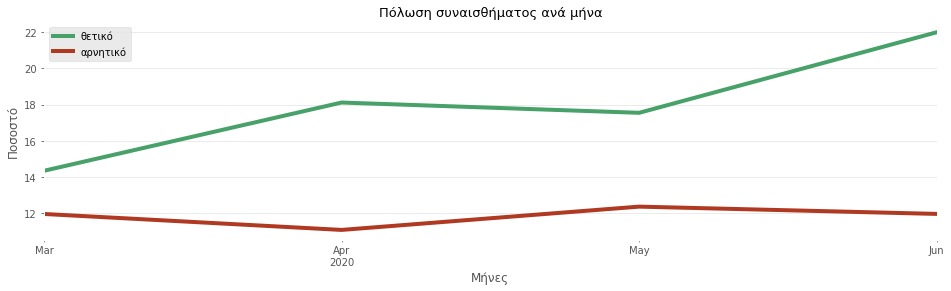

In [98]:
# Διάγραμμα

copy = df_articles.sort_values('Datetime', ascending=True).copy()
plt.style.use('ggplot')
copy.set_index('Datetime' , inplace=True)

# month end frequency
ax = copy['positivity'].resample('M').mean().plot(figsize=(16,4), color = '#47a169', label='θετικό', linewidth=4)
copy['negativity'].resample('M').mean().plot(figsize=(16,4), ax = ax, label = 'αρνητικό', color = '#b03921', linewidth=4)
plt.title('Πόλωση συναισθήματος ανά μήνα', fontsize=13)
plt.xlabel('Μήνες')
plt.ylabel('Ποσοστό')
plt.legend()
ax.set_facecolor('#fff')
ax.grid(color ='#d7d9d7', linewidth=0.5)

In [99]:
import re

# Παίρνουμε το περιεχόμενο από τη στήλη "body"
raw_full_text = df_articles['body'].str.cat(sep = ' ')

In [100]:
# Αφαίρεση των τόνων
nlp.max_length = 1400000
import unicodedata
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')


filtered_tokens = []
doc = nlp(raw_full_text)
for token in doc:
  word = token.lemma_.lower()
  if not '\n' in word and len(word) > 2 and word != '' and not word in nlp.Defaults.stop_words and not word.isnumeric():
    filtered_tokens.append(strip_accents(word)
                              .replace('πανδημίας', 'πανδημια')
                              .replace('κορωνοιου', 'κορωνοιος')
                              .replace('επιχειρησεο', 'επιχειρηση')
                              .replace('επιχειρησει', 'επιχειρηση')
                              .replace('εταιρεια', 'εταιρια'))

text = ' '.join(filtered_tokens)

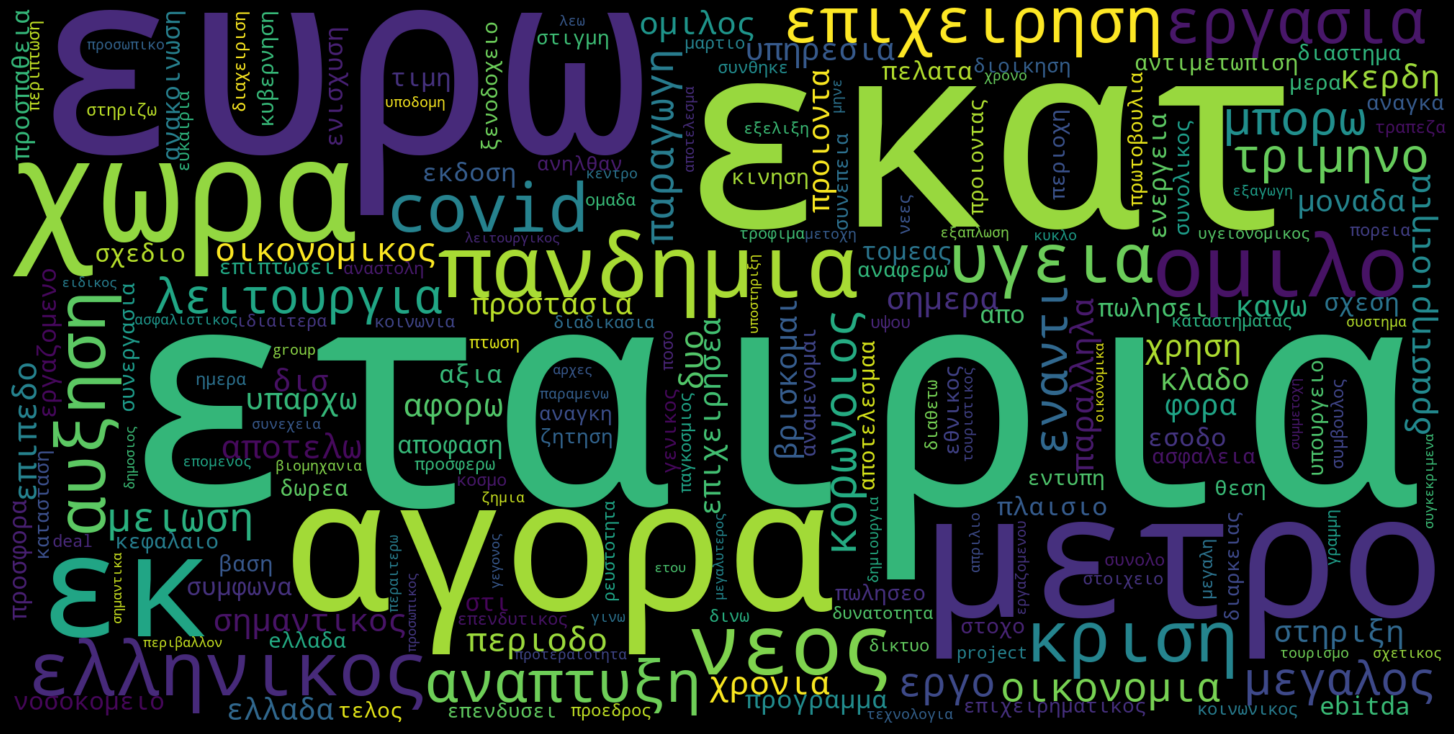

In [101]:
# Οπτικοποίηση λέξεων σε wordcloud

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
 
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    collocations=False
 ).generate(text)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [108]:
# Διάγραμμα με τις 15 πιο συχνές λέξεις 

wordFreq = pd.DataFrame(filtered_tokens, columns=['word'])
top15 = wordFreq['word'].value_counts()[:15]
print(top15)

εταιρια       1036
εκατ.          698
ευρω           693
αγορα          470
μετρο          415
χωρα           411
πανδημια       403
εκ.            402
ομιλο          378
νεος           373
ελληνικος      347
κριση          315
υγεια          287
αυξηση         284
επιχειρηση     274
Name: word, dtype: int64


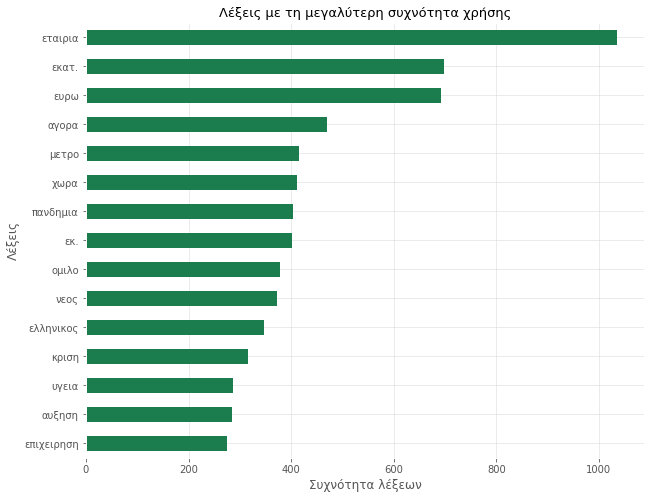

In [123]:
ax = top15.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8), color = '#1b7d4e')

plt.title('Λέξεις με τη μεγαλύτερη συχνότητα χρήσης', fontsize=13)
plt.xlabel('Συχνότητα λέξεων')
plt.ylabel('Λέξεις')
ax.set_facecolor('#fff')
ax.grid(color ='#d7d9d7', linewidth=0.5)

569.3870967741935


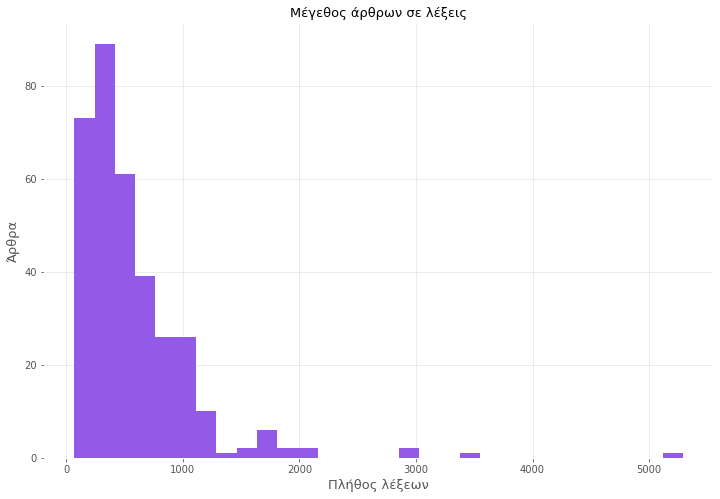

In [136]:
df_articles['word_count'] = df_articles['body'].apply(lambda x: len(x.split()))
print(df_articles['word_count'].mean())
ax = df_articles['word_count'].plot(kind='hist', color = '#925ae6', bins=30, fontsize=10, figsize=(12,8))
ax.set_title('Μέγεθος άρθρων σε λέξεις', fontsize=13)
ax.set_ylabel('Άρθρα', fontsize=13)
ax.set_xlabel('Πλήθος λέξεων', fontsize=13)
ax.set_facecolor('#fff')
ax.grid(color ='#d7d9d7', linewidth=0.5)

In [111]:
# Διανυσματοποίηση

count_vector = vec.fit_transform(df_articles['body'])

In [112]:
results = pd.DataFrame(count_vector.toarray(), columns=vec.get_feature_names()) 

results.head()

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,αυτοκινητοδρομος,αυγουστος,βερολινο,βικτωρια,βοστωνη,γαμηλιο ταξιδι,γεννηση παιδιου,γαιδαρος,γατα,γερμανος,γιαννης,γνωστοποιηση,γυαλια,διακοπη,διευθυντρια σχολειου,διδυμοι,δεξαμενη,δευτερα παρουσια,δευτερον,δημοκρατια,διαρκεια ζωης,διαδρομη,διαλογισμος,διεθνες,διευθυνσεις,δραμα,εξαρτηση,εξωτερικου χωρου,επικοινωνω,επιπτωσεις,...,καρυδια,ωχρος,ελλειπων,προϊοντα,δικαιολογημενο,ενταλματα,κρεατοελλια,αποτυχημενος,σπαταλω,τροποι,ξεπερασμενο,αδιαβροχος,παντρευομαι,βοτανισμα,χωρις βαρος,παραξενα,καλωσορισατε,κρασπεδο,χελωνι,ηχηρο κτυπημα,απολυτως,πλατυς,ανθρωπινο ον,ανεξελεγκτη πυρκαγια,απροσδοκητα ευρημα,μαραμενο,αλιμονο,επιδεινωνεται,αποσπω βιαια,καρπος του χεριου,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


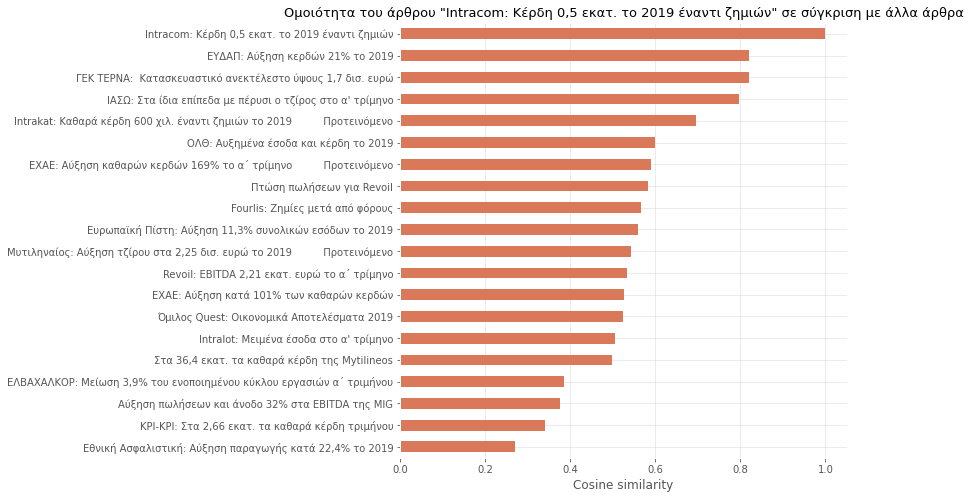

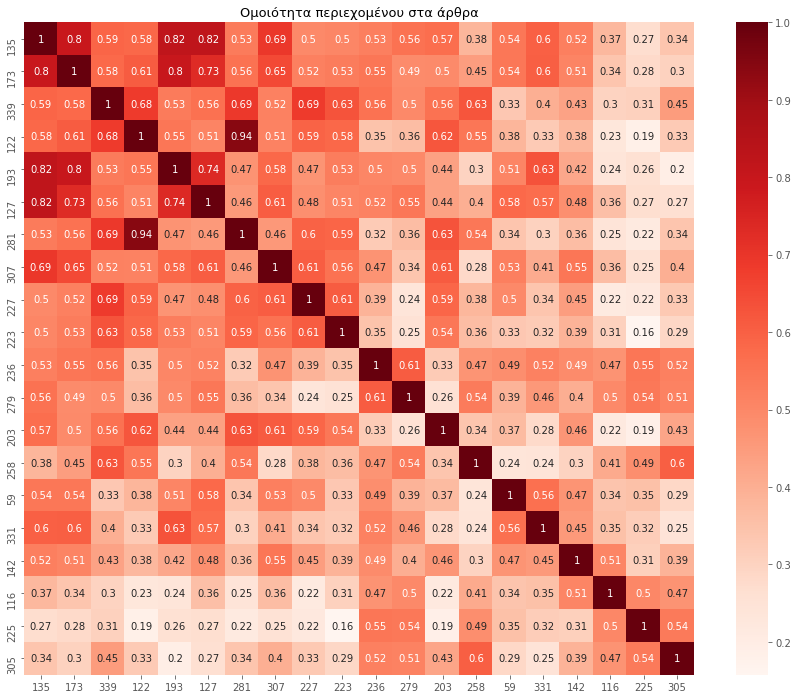

In [125]:
def smart_truncate(content, length=100, suffix='...'):
    if len(content) <= length:
        return content
    else:
        return ' '.join(content[:length+1].split(' ')[0:-1]) + suffix

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words= nlp.Defaults.stop_words, max_features=500)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(df_articles['body']) 

results = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf_vectorizer.get_feature_names()) 
results.head()

# Ομοιότητα κειμένων

from sklearn.metrics.pairwise import cosine_similarity
arr = cosine_similarity(tfidf_matrix_train, tfidf_matrix_train)

# Φτιάχνουμε DataFrame με το αποτέλεσμα του cosine_similarity
plt_df = pd.DataFrame(arr)

# Εύρεση των κορυφαίων 20 ομοιοτήτων
# Δημιουργώ έναν πίνακα με τα scores. Κάθε γραμμή περιέχει το index της γραμμής
# από το plt_df καθώς και το άρθροισμα των 20 άρθρων με το μεγαλύτερο similarity
scores = []
for index, row in plt_df.iterrows():
  scores.append({ 'i' : index, 'similarity_score': row.sort_values(ascending = False).head(20).sum()})
  # Κορυφαίο σε σχέση με το δεύτερο σε ομοιότητα
  # scores.append({ 'i' : index, 'similarity_score': row.sort_values(ascending = False).iloc[1]})

# Φτιάχνω DataFrame με τα scores για να κάνω πράξεις
scores = pd.DataFrame(scores)
# Παίρνω τα 20 με το μεγαλύτερο score
top20scores = scores.sort_values('similarity_score', ascending=False).head(20)

# Από το plt_df παίρνω τα άρθρα που το index τους είναι μέσα στο top20scores
# καθώς και ΜΟΝΟ τις στήλες που επίσης είναι στα 20 κορυφαία
top20similar =  plt_df.loc[list(top20scores['i'])][list(top20scores.head(20)['i'])]
# print(top20similar.head(5))

# Plot για το άρθρο με τις μεγαλύτερες ομοιότητες με τα άλλα άρθρα (στη θέση 0)
top20similar_tmp = top20similar.copy()
dict = {}
for col in top20similar_tmp.columns:
  dict.update({col : df_articles.loc[col]['title'] }) # αντιστοίχιση του index με τον τίτλο 

top20similar_tmp = top20similar_tmp.rename(columns=dict)
ax = top20similar_tmp.iloc[0].sort_values(ascending=True).plot(kind = 'barh', color='#d97959', figsize=(8, 8))
plt.title('Ομοιότητα του άρθρου "' + top20similar_tmp.columns[0] + '" σε σύγκριση με άλλα άρθρα', fontsize=13)
plt.xlabel('Cosine similarity')
ax.set_facecolor('#fff')
ax.grid(color ='#d7d9d7', linewidth=0.5)
# Plot με τα 20 κορυφαία σε ομοιότητα άρθρα
plt.figure(figsize=(15,12))
sns.heatmap(top20similar, annot=True, cmap=plt.cm.Reds)
plt.title('Ομοιότητα περιεχομένου στα άρθρα', fontsize=13)
plt.show()
